# VAE Agent

In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

## Collect HTML files

Load the HTML files

In [2]:
files = []

for f in os.listdir(os.path.join(os.getcwd(),'html')):
    fd = open(os.path.join(os.getcwd(),'html',f),'r')
    content = fd.read()
    files.append(content)
    fd.close()

Add a mock file as a concatentation of a previous one

In [3]:
files.append(files[0]*10)

## Preprocess the files

Define the padding and trimming parameters

In [4]:
padding='post'

maxlen=200
truncating='post'

Load the tokenizer

Show an example of tokenization

In [5]:
SQLi_tokenizer = joblib.load('ignore_tokenizer_20210318105336141483')

Convert the pages into token sequences:

In [6]:
tokens_list = SQLi_tokenizer.texts_to_sequences(files)

Pad and trim the sequences to fit them into an array:

In [7]:
tokens_array = keras.preprocessing.sequence.pad_sequences(tokens_list, padding=padding, maxlen=maxlen, truncating=truncating)

## Defining VAE

Instantiating a VAE module built following [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/).

*Sampling layer with reparametrization trick* $z_i\sim\mathcal{N}(\mu_\phi, \sigma_\phi)$

In [8]:
class Sampling(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

*Encoder* $Q_\phi(z \vert x)$

In [9]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200,))

x = layers.Dense(100,activation='relu')(encoder_inputs)
x = layers.Dense(25,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          20100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           2525        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            52          dense_1[0][0]                    
____________________________________________________________________________________________

*Decoder* $P_\theta(x\vert z)$

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(25,activation='relu')(latent_inputs)
x = layers.Dense(100,activation='relu')(x)
decoder_outputs = layers.Dense(200,activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
Total params: 22,875
Trainable params: 22,875
Non-trainable params: 0
_________________________________________________________________


*VAE with KL+reconstruction loss*

In [11]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)           
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = keras.losses.mean_squared_error(data,reconstruction)
            #reconstruction_loss = tf.reduce_sum(keras.losses.mean_squared_error(data,reconstruction), axis=1)
            kl_loss = -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = (tf.reduce_sum(kl_loss,axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

## Loading the VAE

Loading the model weights

In [12]:
vae = VAE(encoder,decoder)
vae.load_weights('ignore_vae_W_20210321101402420412')

Checking the weights

## Define a mock server

We generate the actions for our server.

In [13]:
from generate_actions import generate_actions
actions = generate_actions()

We import and instantiate a new server.

In [14]:
import SQLiServer_2 as SQLiServer
env = SQLiServer.mockSQLenv(actions,files)

Game setup with a random query


## Running an agent

In [15]:
n_episodes = 2000

In [16]:
import VAEAgent_2 as VAEAgent

In [17]:
agent = VAEAgent.Agent(vae,SQLi_tokenizer,actions)
agent.set_learning_options()
agent.set_padding_options()

In [18]:
steps = []
rewards = []

for _ in range(n_episodes):
    
    env = SQLiServer.mockSQLenv(actions,files)
    agent.reset(env)
    
    agent.run_episode()
    steps.append(agent.steps)
    rewards.append(agent.rewards)

Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Serv

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return

Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " a

Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is 

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I re

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Q

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' u

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action

Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2

Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wr

Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I r

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return

Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. 

Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. 

Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagt

Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Serv

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactical

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action

Server response is 4
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server resp

Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select

Server response is 4
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a rand

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. 

I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Qu

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 off

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number 

Server response is 4
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query

I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response i

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wr

Server response is 1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query with correct number of rows
Server response is 4
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is

Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server re

Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 3:

Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return 

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the corre

I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 42:  u

I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: '

Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server resp

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query with correct number of rows
Server response is 4
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query 

I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactica

Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union 

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct explorato

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntac

Server response is 0
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 

Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escap

Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag 

Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game 

Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Fla

Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server resp

Server response is -1
I received action 40:  union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Quer

Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select fla

Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntacticall

Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct

Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " an

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtab

Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received act

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from 

Server response is 2
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is sy

Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select

Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically w

Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag fr

Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contai

Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' an

Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I receive

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I retu

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactic

Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntacti

Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received ac

Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntacti

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Qu

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong

Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21:

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wro

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received a

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server resp

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is sy

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 16: " union select flag,flag,fla

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically 

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Serve

Server response is 0
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactica

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I receiv

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offs

Server response is 4
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wron

Server response is 4
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server 

Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limi

Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has t

Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response

Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wro

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. 

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30

Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntac

Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query with correct number of rows
Server response is 4
I received action 2: " union select 1#
Query with correct number of rows
Server response is 4
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query i

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I r

Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 

Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I

Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 2: " union select 1#
Query with correct number of rows
Server response is 4
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#


Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -

Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flag

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select fl

Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server resp

Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " u

Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offs

Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query 

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query i

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Quer

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 36:  union select 1#

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query

Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically 

Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct esc

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable li

Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntacticall

Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 5: " union select 1,2 limit 1 offset 1#
Quer

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0


Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select f

Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 7: " union select 1,2,3 limit 1 off

Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong.

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 

Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is synta

Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response i

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong numbe

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contain

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is

Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I

Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I r

Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but

Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query

Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory actio

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 9: " union se

Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Que

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag

Server response is 1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limi

Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. 

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is synt

Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received ac

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I ret

Server response is 2
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is 4
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wr

Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and 

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number 

Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable 

Server response is 4
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, bu

Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 o

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows

Server response is 4
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server respon

Server response is 0
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number o

Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from

Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong numbe

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0

Server response is 4
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (b

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  a

Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I ret

Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. 

Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select

Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4

Server response is 0
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Ser

Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I r

Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I receiv

Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 21: ' union select 1,2#
Query with correct number of rows
Server response is 4
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Fl

Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game rese

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntact

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response i

Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable li

Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union

Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union selec

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received ac

Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server respons

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select fla

Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I rece

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return

Server response is 1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Se

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit

Server response is 0
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union sel

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Q

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response i

Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Serv

Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Serv

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1

Server response is -1
I received action 6: " union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag fr

Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: 

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Serv

Server response is 1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is s

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received act

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 

Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wro

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received acti

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server r

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I r

Server response is 2
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
S

Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape,

Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limi

Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wro

Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I retur

Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union

Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " uni

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received acti

Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query with correct number of ro

Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query i

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape,

Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Serve

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 l

Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1

Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 14: " union select flag,flag,flag from Flagta

Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactica

Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 23: ' union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is 

Server response is -1
I received action 40:  union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correc

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  un

Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received actio

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I re

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received a

Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I ret

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 28: '

Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtab

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 5: " union sel

Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I r

Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42: 

Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I recei

Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query with correct number of rows
Server response is 4
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0


Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I ret

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 5: " union select 1,

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Qu

Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#


Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 

Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server res

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically w

Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offs

Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server

Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union sel

Server response is 1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Serv

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response i

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag 

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I retu

Server response is 0
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,

Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server respons

Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I

Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select 

Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: '

Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a rando

Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query with correct number of rows
Server response is 4
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Fla

Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1


Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
G

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntac

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response

Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union se

Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but c

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,

Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntac

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 31: ' union select flag,flag,flag from 

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offs

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically 

Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is 

Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query with correct number of rows
Server response is 

Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wron

Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query h

Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I rece

Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag fro

Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9:

Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I rec

Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return

Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I receive

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
G

Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1

Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response i

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag 

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
G

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 lim

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server res

Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is 

Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Fla

Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Que

Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response 

Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows.

Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I rece

Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server

Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number 

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " 

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactica

Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -

Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escap

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17

Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I recei

Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I

Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 o

Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wr

Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  un

Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I r

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically w

Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Serve

Server response is 0
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random qu

Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 

Server response is -1
I received action 21: ' union select 1,2#
Query with correct number of rows
Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server 

Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server res

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Qu

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 

Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wro

Server response is -1
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1

Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " unio

Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but c

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I re

Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query is syntactically wrong. I return

Server response is 1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag

Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I

Server response is 1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: "

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong

Server response is 1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Ser

Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union s

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I receiv

Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I ret

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new r

Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I r

Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 30: ' union select flag,flag from Flagtable

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query with correct number of rows
Server response is 4
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offse

Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received actio

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. 

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received acti

Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Q

Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I retur

Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I receive

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable l

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1

Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 36:  union select 1#
Query has the correct escape, but contains

Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 of

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of 

Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 42:  union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I r

Server response is 2
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received 

Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 

Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received a

Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is synt

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offs

Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 

Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactic

Server response is 4
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from

Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query

Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Ser

Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntacticall

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the w

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Quer

Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Fl

Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 43:  union select 

Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows


Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query with correct number of rows
Se

Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,

Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 lim

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag fro

Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: "

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I recei

Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I rec

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2

Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is synt

Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I rece

Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I receive

Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#

Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 li

Server response is 4
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, b

Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server respo

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I retu

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game re

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 l

Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union

Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union selec

Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag ca

Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,fl

Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 lim

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the

Server response is 2
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response 

Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response i

Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable l

Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has 

Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24:

Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2

Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received a

Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union s

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server re

Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I receive

Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I receiv

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server respon

Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Se

Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " u

Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  u

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I 

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 

Server response is 4
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query with correct number of rows
Server response is 4
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number o

Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactica

Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flag

Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,

Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 

I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0


Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union

Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Q

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union sel

Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  un

Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#


Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received a

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union s

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game

Server response is 4
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, 

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limi

Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I receive

Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable

Server response is -1
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1

Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offs

Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 13: " union select flag,f

Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1

Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, b

Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactica

Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 32: ' union select flag,flag,f

Server response is 1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 6: " union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is synt

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 13: " union sel

Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is 

Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 33: ' union

Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 46:  union select flag from Flagtable limit 1 offset 2#

Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is 4
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5

Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactica

Server response is 1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I r

I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 off

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 21: ' union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 of

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I receive

Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Que

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is 

Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query with correct number of rows
Server response is 4
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16:

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server resp

Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically 

Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntacti

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I re

Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 4: " union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 2: " union select 1#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Quer

Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I rece

Server response is 0
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query has the correct esca

Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query i

Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of row

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22

Server response is 4
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 12: " union se

Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 5: " union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server res

Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 27: ' union select 1,2,3,4,5#
Query with correct number

Server response is -1
I received action 36:  union select 1#
Query with correct number of rows
Server response is 4
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1

Server response is 0
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the cor

Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 6: " union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I re

Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically 

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I recei

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)

Server response is 4
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server res

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 20: ' union select 1 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server re

Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the 

Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows

Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query with correct number of rows
Server response is 4
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically

Server response is 0
I received action 40:  union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 11: " union select 1,2,

Server response is 1
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 20: ' union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Que

Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Serve

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 0: " and "1"="1
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#


Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union sel

Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received act

Server response is -1
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 8: " union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 42:  union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 21: ' union select 1,2#
Query is syntactica

Server response is -1
I received action 25: ' union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0


Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 39:  union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#


Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query ha

Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 4: " union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 46:  union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactica

Server response is -1
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Query is syntactically wr

Server response is 4
I received action 33: ' union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query has the correct escape, but cont

Server response is -1
I received action 50:  union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 26: ' union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 of

Server response is 2
I received action 13: " union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 1: " and "1"="2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 38:  union

Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 3: " union select 1 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has

Server response is 4
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query with correct number of rows
Server response is 4
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  a

Server response is -1
I received action 1: " and "1"="2
Query is syntactically wrong. I return -1
Server response is -1
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 3: " union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query with correct number of rows
Server response is 4
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server

Server response is 0
I received action 19: ' union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received actio

Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 32: ' union select flag,flag,flag,flag from Flagtable limi

Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query with correct number of rows
Server response is 4
I received action 32: ' union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wro

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 28: ' union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 38:  union select 1,2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query has the 

Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 9: " union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server respons

Server response is -1
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 34:  and 1=1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 36:  union select 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 25: ' union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 44:  union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 41:  union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server 

Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 27: ' union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 23: ' union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 49:  union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Query is syntactical

Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 45:  union select 1,2,3,4,5 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 43:  union select 1,2,3,4 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 12: " union select flag from Flagtab

Server response is 0
I received action 31: ' union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 40:  union select 1,2,3#
Query is syntactically wrong. I return -1
Server response is -1
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 39:  union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 2: " union select 1#
Query with correct number of rows
Server response is 4
I received action 12: " union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received

Server response is 2
I received action 15: " union select flag,flag,flag,flag from Flagtable limit 1 offset 2#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 48:  union select flag,flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 5: " union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 22: ' union select 1,2 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 10: " union select 1,2,3,4,5#
Query with correct number of rows
Server response is 4
I received action 11: " union select 1,2,3,4,5 limit 1 offset 1#
Query with correct number of 

Server response is -1
I received action 22: ' union select 1,2 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 10: " union select 1,2,3,4,5#
Query is syntactically wrong. I return -1
Server response is -1
I received action 18: ' and '1'='2
Correct exploratory action for the escape. I return 2
Server response is 2
I received action 24: ' union select 1,2,3 limit 1 offset 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 47:  union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 19: ' union select 1#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 17: ' and '1'='1
Correct exploratory action for the escape. I return 1
Server response is 1
I received action 29: ' union select fla

Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 8: " union select 1,2,3,4#
Query has the correct escape, but contains the wrong number of rows. I return 0
Server response is 0
I received action 30: ' union select flag,flag from Flagtable limit 1 offset 2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 7: " union select 1,2,3 limit 1 offset 1#
Query with correct number of rows
Server response is 4
I received action 14: " union select flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received act

Server response is 0
I received action 35:  and 1=2#
Query is syntactically wrong. I return -1
Server response is -1
I received action 17: ' and '1'='1
Query is syntactically wrong. I return -1
Server response is -1
I received action 37:  union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 20: ' union select 1 limit 1 offset 1#
Query is syntactically wrong. I return -1
Server response is -1
I received action 42:  union select 1,2,3,4#
Query is syntactically wrong. I return -1
Server response is -1
I received action 16: " union select flag,flag,flag,flag,flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3
Game setup with a random query
Game reset (but not reinitialized with a new random query!)
Game reset
I received action 29: ' union select flag from Flagtable limit 1 offset 2#
Flag captured. I return 3
Server response is 3


## Saving the agent

In [19]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
joblib.dump(agent.Q, 'ignore_VAEagent_Q_'+timestamp)

['ignore_agent_Q_20210321101808884934']

## Checking the agent

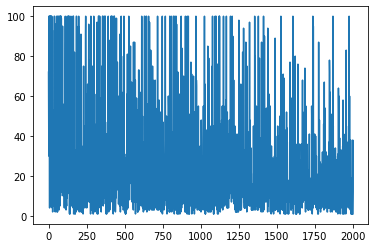

In [20]:
plt.plot(steps)

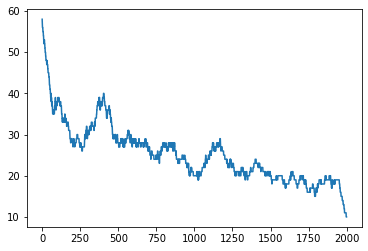

In [21]:
from scipy.ndimage import uniform_filter1d
smoothed_steps = uniform_filter1d(steps,size=100,mode='nearest')
plt.plot(smoothed_steps)